In [62]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

import ThetaoSectors as TS


In [1]:
exp_name='B852'

start_dir='/perm/nk0j/ecearth3-cmip6/runtime/classic'
run_dir = f'/ec/res4/scratch/nk0j/ecearth3-cmip6/{exp_name}'
#run_dir = f'/ec/res4/scratch/nlcd/r9469-cmip6-bisi-knmi/{exp_name}'
#run_dir = f'/ec/res4/scratch/nlcd/r9469-cmip6-bisi-knmi/{exp_name}/'

In [2]:
leg_number='084'
year='2098'

In [65]:
########################## File definition #########################
## Paths
path_input = f'{start_dir}/fwf/interactive/input/'
path_output = f'{start_dir}/fwf/interactive/forcing_files/{exp_name}/'

## Input data
## Output file from nemo: input file for freshwater forcing
file_thetao = f'{run_dir}/output/nemo/{leg_number}/{exp_name}_1m_{year}0101_{year}1231_opa_grid_T_3D.nc' #other output format
file_area = f'{path_input}/areacello_Ofx_EC-Earth3_historical_r1i1p1f1_gn.nc'



In [66]:
## Open thetao dataset + rename dimensions (to be consistent with areacello file)
ds = xr.open_dataset(file_thetao)
ds = ds.rename({'y':'j','x':'i','nav_lon':'longitude','nav_lat':'latitude','olevel':'lev'})

## Compute time mean value over annual file 
ds_thetao_year = ds['thetao'].mean('time_counter')

# Read lev bnds
ds_lev_bnds = ds['olevel_bounds']

## Open areacello dataset
ds_area = xr.open_dataset(file_area)




In [67]:
ds_thetao_year

<xarray.DataArray 'thetao' (lev: 75, j: 292, i: 362)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    latitude   (j, i) float32 ...
    longitude  (j, i) float32 ...
  * lev        (lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: j, i

In [68]:

def nearest_above(my_array, target):
    '''
    Find nearest value in array that is greater than target value and return corresponding index
    
    Args:
        my_array: dataarray with (depth) values
        target: target depth

    Returns:
        index of nearest value in array that is greater than target value 
    '''
    diff = my_array - target
    mask = np.ma.less_equal(diff, 0)
    # We need to mask the negative differences and zero
    # since we are looking for values above
    if np.all(mask):
        return None # returns None if target is greater than any value
    masked_diff = np.ma.masked_array(diff, mask)
    # Returns the index of the minimum value
    return masked_diff.argmin() 

def nearest_below(my_array, target):
    '''
    Find nearest value in array that is smaller than target value and return corresponding index
    
    Args:
        my_array: dataarray with (depth) values
        target: target depth

    Returns:
        index of nearest value in array that is smaller than target value 
    '''

    diff = target - my_array
    mask = np.ma.less_equal(diff, 0)
    # We need to mask the positive differences and zero
    # since we are looking for values below
    if np.all(mask):
        return None # returns None if target is smaller than any value
    masked_diff = np.ma.masked_array(diff, mask)
    # Returns the index of the minimum value
    return masked_diff.argmin()

def lev_weighted_mean(ds_var,ds_lev_bnds,depth_bottom, depth_top):
    '''
    Compute volume weighted mean oceanic temperature over specific depth 
    layers (centered around ice shelf depth)
    
    Args:
        ds_var: dataarray with variable (optional: area-weighted mean)
        ds_lev_bnds: dataarray with lev_bnds
        depth_bottom: bottom_depth
        depth_top: top_depth
    
    Returns: 
       Depth weighted mean oceanic temperature 
       If input is area-weighted, output is volume-weighted

    '''   
    # Find oceanic layers covering the depth bounds and take a slice of these
    # layers
    lev_ind_bottom= nearest_above(ds_lev_bnds[:,1],depth_bottom)
    lev_ind_top = nearest_below(ds_lev_bnds[:,0],depth_top)
    levs_slice = ds_var.isel(lev=slice(lev_ind_top,lev_ind_bottom+1))
    
    # Create weights for each oceanic layer, correcting for layers that fall only partly within specified depth range 
    lev_bnds_sel = ds_lev_bnds.values[lev_ind_top:lev_ind_bottom+1]
    lev_bnds_sel[lev_bnds_sel > depth_bottom] = depth_bottom
    lev_bnds_sel[lev_bnds_sel < depth_top] = depth_top
    # Weight equals thickness of each layer
    levs_weights = lev_bnds_sel[:,1]-lev_bnds_sel[:,0] 
    # DataArray required to apply .weighted on DataArray
    levs_weights_DA = xr.DataArray(levs_weights,coords={'lev': levs_slice.lev},
             dims=['lev'])
    
    # Compute depth weighted mean of ocean slice
    levs_slice_weighted = levs_slice.weighted(levs_weights_DA)
    levs_weighted_mean = levs_slice_weighted.mean(("lev"))
    
    # Return layer-weighted ocean temperature
    return levs_weighted_mean

In [69]:


# Compute layer weighted mean
thetao_layer_weighted_mean = lev_weighted_mean(ds_thetao_year,ds_lev_bnds, 700, 400)


In [70]:
thetao_layer_weighted_mean

<xarray.DataArray 'thetao' (j: 292, i: 362)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    latitude   (j, i) float32 -78.39 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
    longitude  (j, i) float32 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
Dimensions without coordinates: j, i

In [71]:
ds_thetao_year[0,:,:] #top level

<xarray.DataArray 'thetao' (j: 292, i: 362)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    latitude   (j, i) float32 ...
    longitude  (j, i) float32 ...
    lev        float32 0.5058
Dimensions without coordinates: j, i

In [72]:
longitude=ds['longitude']
latitude=ds['latitude']
thetao=thetao_layer_weighted_mean #ds_thetao_year[0,:,:] #top level
thetao


<xarray.DataArray 'thetao' (j: 292, i: 362)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    latitude   (j, i) float32 -78.39 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
    longitude  (j, i) float32 72.5 73.5 74.5 75.5 ... 73.05 73.04 73.0 72.99
Dimensions without coordinates: j, i

In [73]:
x=longitude.data
y=latitude.data
thetao=thetao.data

/perm/nk0j/miniconda3/envs/ecearth/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


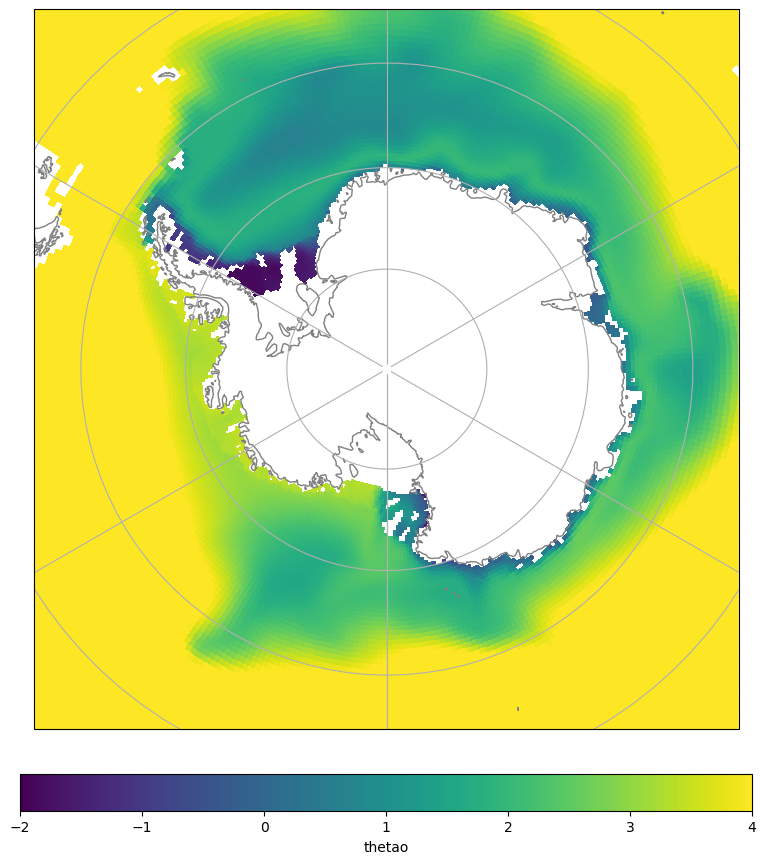

In [74]:
# Plot Antarctic ocean temperature
f = plt.figure(figsize=(12,9), constrained_layout=True)
ax = f.add_axes([.38,0,.61,1], projection=ccrs.SouthPolarStereo())
ax.set_extent([-180,180,-90,-55], ccrs.PlateCarree()) # x0, x1, y0, y1 in degrees
ax.gridlines()
ax.coastlines(color='grey')

im = ax.pcolormesh(x, y, thetao, vmin=-2, vmax=4, shading='auto', transform=ccrs.PlateCarree())

cbar = f.colorbar(im, location='bottom', shrink = 1, pad=0.05, ax=ax)
cbar.set_label('thetao')
#plt.colorbar(im)

plt.show()